# 1. 히스토그램 역투영(Histogram backprojection)

- 기준 영상의 히스토그램 정보를 이용하여 입력 영상에서 찾고자 하는 물체를 검출하는 방법
- 물체의 모양은 무시하고 단순히 컬러 분포만으로 검출하는 방법
- 히스토그램을 매핑 함수로 사용하여, 화소 값을 신뢰도 값으로 변환

## 예) 피부색 영역 검출하기
- RGB 색상 공간 => HSL(또는 HLS) 색상 공간으로 변환
  - H(Hue): 색상
  - S(Saturation): 채도
  - L(Lightness): 밝기
<img src='rc/HSL.png' alt='HSL' width="400" heigh="400">

- 밝기(L)는 조명에 따라 쉽게 변할 뿐만 아니라 피부와 비슷한 밝기를 갖는 다른 영역이 여러 군데 존재할 가능성이 높음
- 따라서, 밝기(L)는 무시하고 색상(H)과 채도(S)를 사용함

# 2. 수행 과정

<img src='rc/2d histogram.png' alt='2d histogram' width="800" heigh="600">  

- 기준 영상 $m$에서 구한 히스토그램 $h_m$을 어떤 화소 값이 피부에 해당하는지에 대한 신뢰도 값으로 변환해주는 함수로 사용함
- 새로운 입력 영상 $i$가 주어지면 $h_m$을 이용하여 피부색 영역 검출
- 실제로는 $h_m$ 대신 비율 히스토그램 $h_r$을 사용함

$$
h_{r}(i,j)=min(\frac{\hat{h_m}(i,j)}{\hat{h_i}(i,j)}, 1.0)
$$

<img src='rc/histogram backprojection.png' alt='histogram backprojection' width="800" heigh="600">  

- 결과

<img src='rc/result.png' alt='result' width="600" heigh="600">  


# 3. 장단점

- 한계
  - 비슷한 색 분포를 갖는 다른 물체를 구별 못함
  - 검출 대상이 여러 색 분포를 갖는 경우 여러 개의 모델을 사용해야 하므로 오류 가능성을 높아짐
  - 특히 피부색 검출의 경우 인종에 따라 결과가 달라짐
  - 따라서, 컴퓨터 비전 분야에서는 물체 검출 문제를 풀 때 **모양 특징을 주로 사용**하며, 상황에 따라 **색 정보를 보조적으로 사용함**
  
<br>  

- 장점
  - 물체의 이동이나 회전이 발생하더라도 히스토그램은 불변하므로 성능이 유지됨
  - 물체의 일부가 가려진 경우에도 어느 정도 작동함
  - 따라서, 배경의 색 분포가 균일하면서 물체의 색 분포와 겹치지 않는 경우에 유용함


### [reference]  
  - image - https://github.com/sunkyoo/opencv4cvml/tree/master/ch10/backproj
  [](https://theailearner.com/2019/04/18/histogram-backprojection/)

# 4. Practice
## 1) 기준 영상 정보 확인

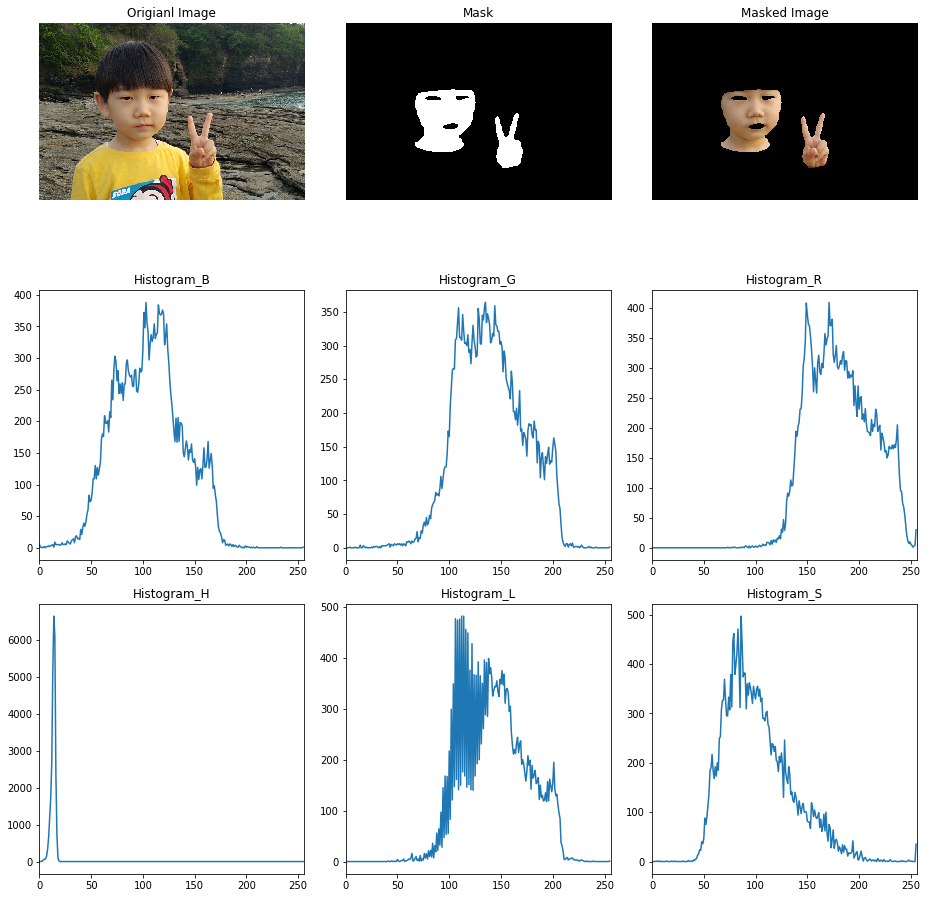

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 기준 영상 읽어오기
img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)
masked_img = cv2.bitwise_and(img_m, img_m, mask=mask)

# 기준 영상의 R,G,B 채널 히스토그램 계산
hist_b = cv2.calcHist([img_m], [0], mask, [256], [0,256])
hist_g = cv2.calcHist([img_m], [1], mask, [256], [0,256])
hist_r = cv2.calcHist([img_m], [2], mask, [256], [0,256])

# RGB -> HSL 변환
hls_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)

# 기준 영상의 H,S,L 채널 히스토그램 계산
hist_h = cv2.calcHist([hls_m], [0], mask, [256], [0,256])
hist_l = cv2.calcHist([hls_m], [1], mask, [256], [0,256])
hist_s = cv2.calcHist([hls_m], [2], mask, [256], [0,256])

# 기준 영상 및 히스토그램 시각화
plt.figure(figsize=(13, 13))

# cv2.cvtColor(img_m, cv2.COLOR_BGR2RGB)
plt.subplot(331), plt.imshow(img_m[...,::-1]), plt.title('Origianl Image'), plt.axis('off')
plt.subplot(332), plt.imshow(mask,'gray'), plt.title('Mask'), plt.axis('off')
plt.subplot(333), plt.imshow(masked_img[...,::-1]), plt.title('Masked Image'), plt.axis('off')

plt.subplot(334), plt.plot(hist_b), plt.title('Histogram_B'), plt.xlim([0,256])
plt.subplot(335), plt.plot(hist_g), plt.title('Histogram_G'), plt.xlim([0,256])
plt.subplot(336), plt.plot(hist_r), plt.title('Histogram_R'), plt.xlim([0,256])

plt.subplot(337), plt.plot(hist_h), plt.title('Histogram_H'), plt.xlim([0,256])
plt.subplot(338), plt.plot(hist_l), plt.title('Histogram_L'), plt.xlim([0,256])
plt.subplot(339), plt.plot(hist_s), plt.title('Histogram_S'), plt.xlim([0,256])

plt.tight_layout()
plt.show()

## 2) 히스토그램 역투영

In [2]:
import cv2
import numpy as np

# 기준 영상 불러오기
img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)

## 기준 영상의 H-S 히스토그램 생성
hls_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)
hist_m = cv2.calcHist([hls_m], [0,2], mask, [181,256], [0,181,0,256])

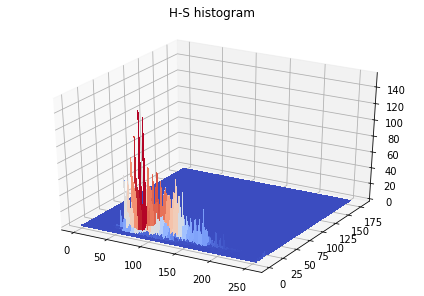

In [3]:
## 기준 영상 피부색 영역 2차원 히스토그램 시각화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_m, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()

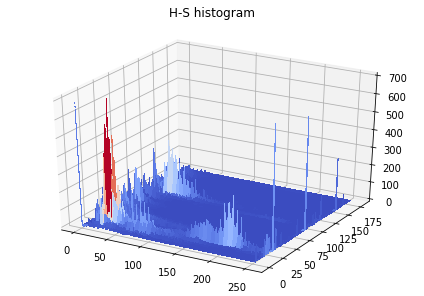

In [4]:
## 입력 영상 2차원 히스토그램 시각화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

img_i = cv2.imread('test.png')
hls_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2HLS)

hist_i = cv2.calcHist([hls_i], [0,2], None, [181,256], [0,181,0,256])
hist_i = np.minimum(hist_i, 700)

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_i, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()

In [5]:
## 입력 이미지의 H-S 히스토그램 계산
img_i = cv2.imread('test.png')
hls_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2HLS)

## 히스토그램 역투영 수행
'''
To do
'''

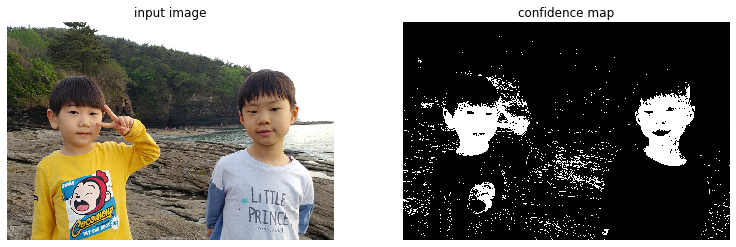

In [6]:
## 결과 시각화
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.imshow(img_i[...,::-1])
plt.axis('off')
plt.title('input image')

plt.subplot(1,2,2)
plt.imshow(result,'gray')
plt.axis('off')
plt.title('confidence map')

plt.show()

## 3) 모폴로지 연산을 통한 개선

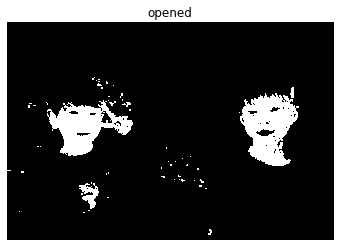

In [7]:
## 모폴로지 연산 적용
'''
To do
'''

plt.imshow(improved, 'gray')
plt.axis('off')
plt.title('improved')

plt.show()

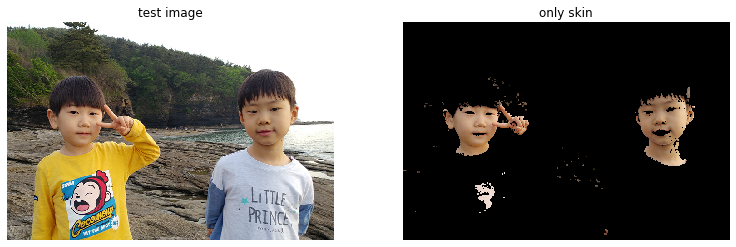

In [8]:
## 피부색 영역 검출
skin = cv2.bitwise_and(img_i, img_i, mask=improved.astype('uint8'))

plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.imshow(img_i[...,::-1])
plt.axis('off')
plt.title('test image')

plt.subplot(1,2,2)
plt.imshow(skin[...,::-1])
plt.axis('off')
plt.title('only skin')

plt.show()